In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    if len(x.shape) == 1:  # only one x observation
        return ((1/3)*(x**2))*(np.sqrt(((x**2)/4)-((x**2)/16)))
    else:
        result = []
        for i in x:
            result.append(((1/3)*(i**2))*(np.sqrt(((i**2)/4)-((i**2)/16))))
        return result

def f2(x):
    if len(x.shape) == 1:  # only one x observation
        return (x**2) + (4 * x) * np.sqrt((((x**2)/4)-((x**2)/16)))
    else:
        result=[]
        for i in x:
            result.append((i**2) + (4 * i) * np.sqrt((((i**2)/4)-((i**2)/16))))
        return np.array(result)

# return the relative fitness of an x value
# compared to the tournament x values: tourn_x,
# based off pareto dominance. Reward is based
# off strong and weak domination
def pareto_dominance(x, tourn_x):
    f_1 = f1(x)
    f_2 = f2(x)
    tourn_f1 = f1(tourn_x)
    tourn_f2 = f2(tourn_x)

    score = 0
    if len(tourn_x.shape) == 1:  # only one x observation
        if np.all(f_1 <= tourn_f1) and np.all(f_2 <= tourn_f2):  # at least equal in all objectives
            score += 2
            if np.any(f_1 < tourn_f1) or np.any(f_2 < tourn_f2):  # strong dominance
                score += 2
        elif np.any(f_1 < tourn_f1) or np.any(f_2 < tourn_f2):  # weak domination
            score += 1
    else:
        for i in range(0, len(tourn_x)):
            for j in range(0, len(tourn_x)):
                if i == j:
                    continue
                for k in range(0, j):
                    pass

            for j in range(1, i):
                pass
            if np.all(f_1 <= tourn_f1[i]) and np.all(f_2 <= tourn_f2[i]):  # at least equal in all objectives
                score += 2
                if np.any(f_1 < tourn_f1[i]) or np.any(f_2 < tourn_f2[i]):  # strong dominance
                    score += 2
            elif np.any(f_1 < tourn_f1[i]) or np.any(f_2 < tourn_f2[i]):  # weak domination
                score += 1

    return score


# Handles more than 2 parents
# Averaging Technique by taking mean of all parent values
def crossover_method_1(par):
    child = np.copy(par[0])
    for j in range(0, np.shape(par[0])[0]):
        child[j] = np.mean(par[:,j])
    return child


# Handles more than 2 parents
# 'intuitive' crossover by uniformly randomly
# inheriting genes from parents
def crossover_method_2(par):
    child = np.copy(par[0])
    n = np.shape(par[0])[0]
    # random indices from parents for child to inherit from
    random_nums = np.random.randint(low=0, high=len(par), size=n)
    for j in range(0, n):
        child[j] = par[random_nums[j]][j]
    return child


# classical Evolutionary Programming Mutation
# log-normal self adaptation
def mutate(par_val, par_sigma):
    n_x = len(par_val)  # number of variables
    tau = 1 / (np.sqrt(2 * np.sqrt(n_x)))
    tau_prime = 1 / (np.sqrt(2 * n_x))
    r = np.random.normal(0, 1, len(par_sigma))
    ch_sigma = par_sigma*np.exp(tau*r+tau_prime*r)
    r = np.random.normal(0, 1, len(par_sigma))
    ch_val = np.copy(par_val)+ch_sigma*r
    return ch_val, ch_sigma

# given a set of parents, their sigma, and cross_method
# produce two offspring, one through crossover only
# and the other through mutation after crossover
# choose the best for survival based off pareto-dominance
def reproduction(par, sigma, cross_method):
    if cross_method == 1:
        child_val = crossover_method_1(par)
        child_sigma = crossover_method_1(sigma)
    else:
        child_val = crossover_method_2(par)
        child_sigma = crossover_method_2(sigma)
    # mutate crossover offspring
    mut_child_val, mut_child_sigma = mutate(child_val, child_sigma)
    # get pareto-dominance between offspring
    f = pareto_dominance(child_val, mut_child_val)
    if f == 4:  # strong domination
        return child_val, child_sigma
    elif f == 2:  # weak domination
        r = np.random.uniform(0, 1, 1)
        if r < 0.5:  # randomly select winner
            return child_val, child_sigma
        else:
            return mut_child_val, mut_child_sigma
    else:  # no domination
        return mut_child_val, mut_child_sigma


# function has been parameterized for our problem, so no initial gen given
# size is # of individuals, var_count is number of variables for our problem
# max_distance is max euclidean similarity distance allowed for solutions,
# max_iter is max iter of inner loop, archive_iter is outer loop -> larger
# iter for archive creates a bigger pareto-front
def evolutionary_strategy_pareto_algorithm(size, var_count, max_distance=2, max_iter=50,
                                           cross_method=1, par_count=2, archive_iter=30):

    lower_bound = [-10] * var_count
    upper_bound = [10] * var_count
    bounds = [upper_bound, lower_bound]
    archive = []
    # outer loop
    for q in range(0, archive_iter):
        # create initial generation with strategy parameters
        init_gen = np.empty(shape=(size, var_count))
        init_sigma = np.empty(shape=(size, var_count))
        for i in range(0, var_count):
            init_sigma[:, i] = np.random.uniform(0.5, 5, size)
            init_gen[:, i] = np.random.uniform(-10, 10, size)
        n, c = init_gen.shape
        tourn_size = int(0.05 * n)

        print("Archive {}".format(q + 1))
        gen = np.copy(init_gen)
        sigma = np.copy(init_sigma)
        # inner loop
        for k in range(0, max_iter):

            # random selection based off number of parents
            selected = []
            for i in range(0, par_count):
                selected.append(np.random.choice(range(0, n), n, replace=False))
            selected = np.asarray(selected).T
            ch_val = []
            ch_sigma = []
            # reproduce from parents
            for i in range(0, n):
                c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)
                ch_val.append(c_v)
                ch_sigma.append(c_s)

            ch_val = np.asarray(ch_val)
            ch_sigma = np.asarray(ch_sigma)
            # check bounds of offspring
            for i in range(0, n):
                for j in range(0, c):
                    if ch_val[i][j] > bounds[0][j]:
                        ch_val[i][j] = bounds[0][j]
                        ch_sigma[i][j] *= .90
                    elif ch_val[i][j] < bounds[1][j]:
                        ch_val[i][j] = bounds[1][j]
                        ch_sigma[i][j] *= .90

            # combine offspring with parents
            parents_offspring_val = np.vstack((gen, ch_val))
            parents_offspring_sigma = np.vstack((sigma, ch_sigma))
            ind = list(range(0, 2*n))
            rel_fit = []
            # compute relative fitness
            for i in range(0, 2*n):
                tourn = np.random.choice(ind[0:i]+ind[(i+1):], tourn_size)
                rel_fit.append(pareto_dominance(parents_offspring_val[i], parents_offspring_val[tourn]))

            if q != 0:  # not first iteration of outer loop
                # loop over each member in archive
                for arch in archive:
                    for i in range(0, 2*n):
                        # calculate euclidean distance
                        dist = np.linalg.norm(arch-parents_offspring_val[i])
                        # if their distance is small -> they're too close,
                        # larger the max distance the more spread out solutions become
                        if dist <= max_distance:
                            # penalize fitness down to 25%
                            rel_fit[i] *= 0.25

            # sort individuals based on relative fitness
            rel_fit = np.asarray(rel_fit)
            sorted_ind = np.asarray(ind)[np.argsort(-rel_fit)]

            # use elitism to take the best half from pooled
            # parents and offspring
            gen = parents_offspring_val[sorted_ind[0:n]]
            sigma = parents_offspring_sigma[sorted_ind[0:n]]

            # calculate best for printing out information
            fit_f1 = f1(gen)
            fit_f2 = f2(gen)
            fit_best_f1 = np.min(fit_f1)
            fit_mean_f1 = np.mean(fit_f1)
            fit_best_f2 = np.min(fit_f2)
            fit_mean_f2 = np.mean(fit_f2)
            msg = "GENERATION {}:\n" \
                  " F1: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n"\
                  " F2: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n".format(k, fit_best_f1, fit_mean_f1, fit_best_f2, fit_mean_f2)
            print(msg)

        # update archive
        if q != 0:
            # loop over every individual in surviving generation
            for j in range(0, len(gen)):
                # indices of members in archive that are dominated by
                # the current individual
                ind_del = []
                f1_arch = f1(np.asarray(archive))
                f2_arch = f2(np.asarray(archive))
                dominated = False
                for i in range(0, len(archive)):
                    # individual strongly dominates member of archive
                    if np.all(f1_arch[i] > fit_f1[j]) and np.all(f2_arch[i] > fit_f2[j]):
                        ind_del.append(i)  # add member index for deletion
                    # individual is strongly dominated by member
                    elif np.all(f1_arch[i] < fit_f1[j]) and np.all(f2_arch[i] < fit_f2[j]):
                        dominated = True
                if len(ind_del) != 0:
                    # delete members that are strongly dominated
                    for index in sorted(ind_del, reverse=True):
                        del archive[index]
                if not dominated:  # weakly dominates members of archive
                    archive.append(gen[j])

        else:  # if first iteration of outer loop, just add best solution from gen
            archive.append(gen[0])

    return np.asarray(archive)


arch = evolutionary_strategy_pareto_algorithm(size=100, var_count=2, max_distance=0.75,
                                              max_iter=40, cross_method=1, par_count=3,
                                              archive_iter=100)

Streaming output truncated to the last 5000 lines.
GENERATION 10:
 F1: 
  Best Fit: 0.01394121170091027, Mean Fit: 6.1656483996878695
 F2: 
  Best Fit: 0.5751346485659501, Mean Fit: 19.947790080448453

GENERATION 11:
 F1: 
  Best Fit: 0.01394121170091027, Mean Fit: 3.435313122519318
 F2: 
  Best Fit: 0.5751346485659501, Mean Fit: 14.557407652418641

GENERATION 12:
 F1: 
  Best Fit: 0.018690823830694196, Mean Fit: 3.2470150613472084
 F2: 
  Best Fit: 0.699285967604109, Mean Fit: 13.729549286959811

GENERATION 13:
 F1: 
  Best Fit: 0.011143302233931666, Mean Fit: 3.0508467067507663
 F2: 
  Best Fit: 0.4953495703129081, Mean Fit: 12.93243617045997

GENERATION 14:
 F1: 
  Best Fit: 0.002410763432271435, Mean Fit: 2.8493318653756963
 F2: 
  Best Fit: 0.1785139860757975, Mean Fit: 12.415425793687527

GENERATION 15:
 F1: 
  Best Fit: 0.002410763432271435, Mean Fit: 1.2265211474350155
 F2: 
  Best Fit: 0.1785139860757975, Mean Fit: 8.613248070879187

GENERATION 16:
 F1: 
  Best Fit: 0.00241076

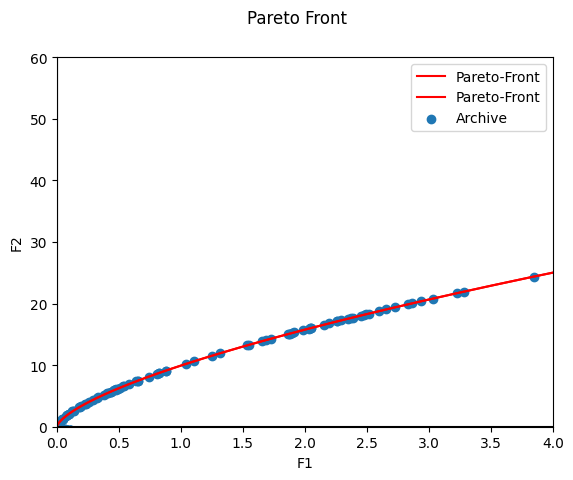

In [2]:
x = np.arange(-4, 4, 0.01).reshape(-1, 2)
plt.plot(f1(x), f2(x), label="Pareto-Front", c="red")
f1_arch = f1(arch)
f2_arch = f2(arch)
plt.scatter(f1_arch, f2_arch, label="Archive")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.suptitle("Pareto Front")
plt.xlim([0, 4])
plt.ylim([0, 60])
plt.show()